# Multivariate risk management.

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms
    
    
- Simple models 
    - Product of univariate distributions
    - Multivariate Normal distribution
    
    
- Kernel Density estimation
    - Univariate case
    - Multivariate case
    
    
- Backtesting
    
    
    
    
    
## References
- [Multivariate Models](https://github.com/qrmtutorial/qrm/blob/master/slides/qrm_06.pdf)
- [Density Estimation](https://scikit-learn.org/stable/modules/density.html)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
# plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'
# %config InlineBackend.figure_formats=["png"]

import warnings
warnings.filterwarnings("ignore")

## Recap -- what we want to do

We want to calculate some risk-metrics for our portfolio. Usually it is Value-at-Risk (VaR) -- a quantile on the distribution of P/L (profit and loss), or returns $r_t$:

$$\mathbf{P}[r_{t+h} \le VaR_{t+h}(q)] = q$$

and Expected Shortfall (ES) -- an expected loss conditional on VaR being violated:

$$ES = \mathbf{E}[r_{t+h} | r_{t+h} \le VaR_{t+h}(q)]$$

The differnce from the univariate case is that we consider portfolio returns $r^{\text{portfolio}}_t$, which depend on a vector of returns of each portfolio's component $r_t = \{r_t^{(j)}\}_{j=1}^n$:

$$ r^{\text{portfolio}}_t = \sum_{j=1}^n w_t^{(j)}r_t^{(j)} = w_t^Tr_t$$

(It's not 100% correct formula but rather an approximation, think why)

Let's try to model a random vector $r_t$ using different approaches

## Data

### Upload and visualize data

Get the data for the Dow Jones Industrial Average stocks by specifying the stock tickers, start date, and end date

https://finance.yahoo.com/quote/%5EDJI/components?p=%5EDJI

In [2]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [3]:
import yfinance as yf

selected_companies = ['AAPL',  'MSFT', 'MMM', 'NKE', 'GS']

dwj_companies = 'VZ UNH JNJ PG MRK RTX KO WBA MMM WMT MSFT IBM INTC AAPL CSCO '
dwj_companies += 'NKE CAT PFE XOM MCD JPM HD V GS DIS AXP CVX TRV BA' # DOW

data = yf.download(dwj_companies, '2019-01-01','2024-04-29' , group_by="column")

data.head()

[*********************100%%**********************]  29 of 29 completed


Price       Adj Close                                                \
Ticker           AAPL        AXP          BA         CAT       CSCO   
Date                                                                  
2019-01-02  37.845043  88.524506  314.645142  110.966423  36.324730   
2019-01-03  34.075401  86.796570  302.100525  106.690361  35.003677   
2019-01-04  35.530052  90.707642  317.822571  112.520546  36.580414   
2019-01-07  35.450966  91.200035  318.823395  112.590775  36.827587   
2019-01-08  36.126766  91.645943  330.891937  113.942970  37.125896   

Price                                                                 ...  \
Ticker            CVX         DIS          GS          HD        IBM  ...   
Date                                                                  ...   
2019-01-02  87.876015  107.304619  151.677521  151.525131  85.522606  ...   
2019-01-03  86.192955  104.704964  149.455673  148.185471  83.815277  ...   
2019-01-04  87.979218  107.934837  154.340210  152.588547  87.088913  ...   
2019-01-07  89.122429  108.870316  155.195419  155.594299  87.705040  ...   
2019-01-08  88.733414  109.717178  154.622360  156.341339  88.952126  ...   

Price         Volume                                                  \
Ticker           PFE        PG       RTX      TRV      UNH         V   
Date                                                                   
2019-01-02  26430315   9843900   9361752  1793400  4063600   8788000   
2019-01-03  28503533   9820200   8884258  1887500  4623200   9428300   
2019-01-04  27145348  10565700  10083317  1793900  5367600  11065800   
2019-01-07  20995469   9012500   8314601  1082800  4133000  12928000   
2019-01-08  19677231   9551300   5951282  1403900  3618600   9243000   

Price                                              
Ticker            VZ      WBA       WMT       XOM  
Date                                               
2019-01-02  13969700  5528100  24458100  16727200  
2019-01-03  19245400  5853200  24831900  13866100  
2019-01-04  17035800  6868600  24087300  16043600  
2019-01-07  16349000  6192500  23369100  10844200  
2019-01-08  21424600  6548100  21602700  11439000  

[5 rows x 174 columns]

In [4]:
prices = data['Adj Close'].dropna()

print(prices.shape)
prices.head()

(1339, 29)


Ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,37.845043,88.524506,314.645142,110.966423,36.324730,87.876015,107.304619,151.677521,151.525131,85.522606,...,33.390144,79.410713,59.838741,104.029121,225.071289,128.224426,42.104740,53.644470,28.534632,53.465618
2019-01-03,34.075401,86.796570,302.100525,106.690361,35.003677,86.192955,104.704964,149.455673,148.185471,83.815277,...,32.455986,78.853912,57.175564,102.158958,218.933594,123.603683,42.255070,53.084682,28.387892,52.644722
2019-01-04,35.530052,90.707642,317.822571,112.520546,36.580414,87.979218,107.934837,154.340210,152.588547,87.088913,...,33.197136,80.463364,59.131512,105.190201,221.494034,128.928650,42.360291,54.850746,28.565205,54.585709
2019-01-07,35.450966,91.200035,318.823395,112.590775,36.827587,89.122429,108.870316,155.195419,155.594299,87.705040,...,33.374702,80.141487,59.103878,104.853409,221.919235,131.253510,42.630871,55.166119,28.901485,54.869576
2019-01-08,36.126766,91.645943,330.891937,113.942970,37.125896,88.733414,109.717178,154.622360,156.341339,88.952126,...,33.529110,80.437286,60.170273,104.445679,224.886414,131.967346,43.878517,56.269913,29.103245,55.268520


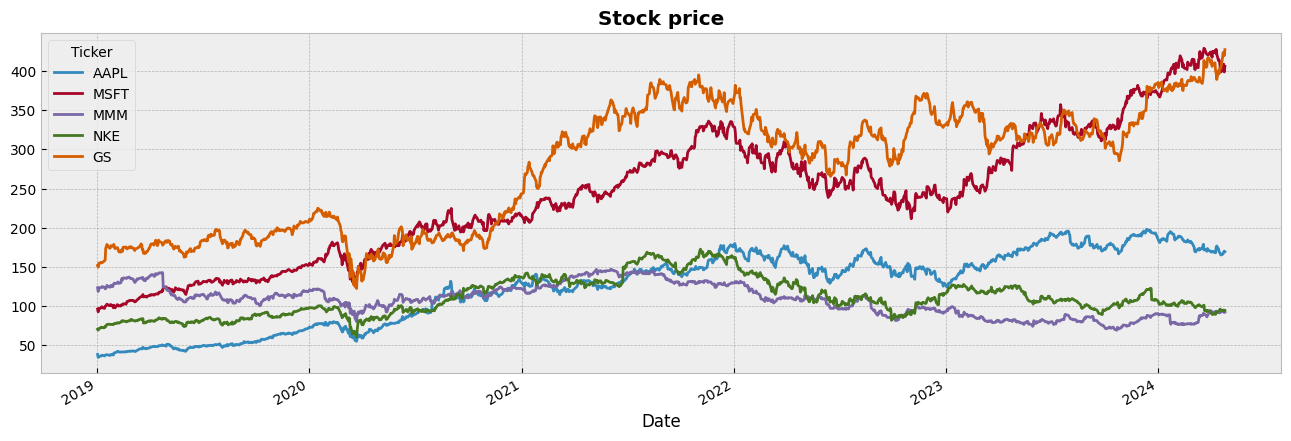

In [5]:
prices.loc[:,selected_companies].plot(figsize=(16, 5))
plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

In [6]:
prices.index = prices.index.to_period(freq='d')
returns = prices.pct_change().dropna()

returns.head()

Ticker,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.019519,-0.039869,-0.038535,-0.036368,-0.019153,-0.024227,-0.014648,-0.022040,-0.019963,...,-0.027977,-0.007012,-0.044506,-0.017977,-0.027270,-0.036036,0.003570,-0.010435,-0.005143,-0.015354
2019-01-04,0.042689,0.045060,0.052042,0.054646,0.045045,0.020724,0.030847,0.032682,0.029713,0.039058,...,0.022836,0.020411,0.034210,0.029672,0.011695,0.043081,0.002490,0.033269,0.006246,0.036870
2019-01-07,-0.002226,0.005428,0.003149,0.000624,0.006757,0.012994,0.008667,0.005541,0.019698,0.007075,...,0.005349,-0.004000,-0.000467,-0.003202,0.001920,0.018032,0.006388,0.005750,0.011772,0.005200
2019-01-08,0.019063,0.004889,0.037853,0.012010,0.008100,-0.004365,0.007779,-0.003692,0.004801,0.014219,...,0.004626,0.003691,0.018043,-0.003889,0.013371,0.005439,0.029266,0.020009,0.006981,0.007271
2019-01-09,0.016982,0.001825,0.009691,0.003853,-0.005510,0.013420,0.011219,0.006273,0.010343,0.007177,...,-0.002073,-0.016332,0.003857,0.007128,0.001439,0.011769,-0.012583,0.012050,-0.003256,0.005275


### Plot histograms

<Figure size 700x700 with 0 Axes>

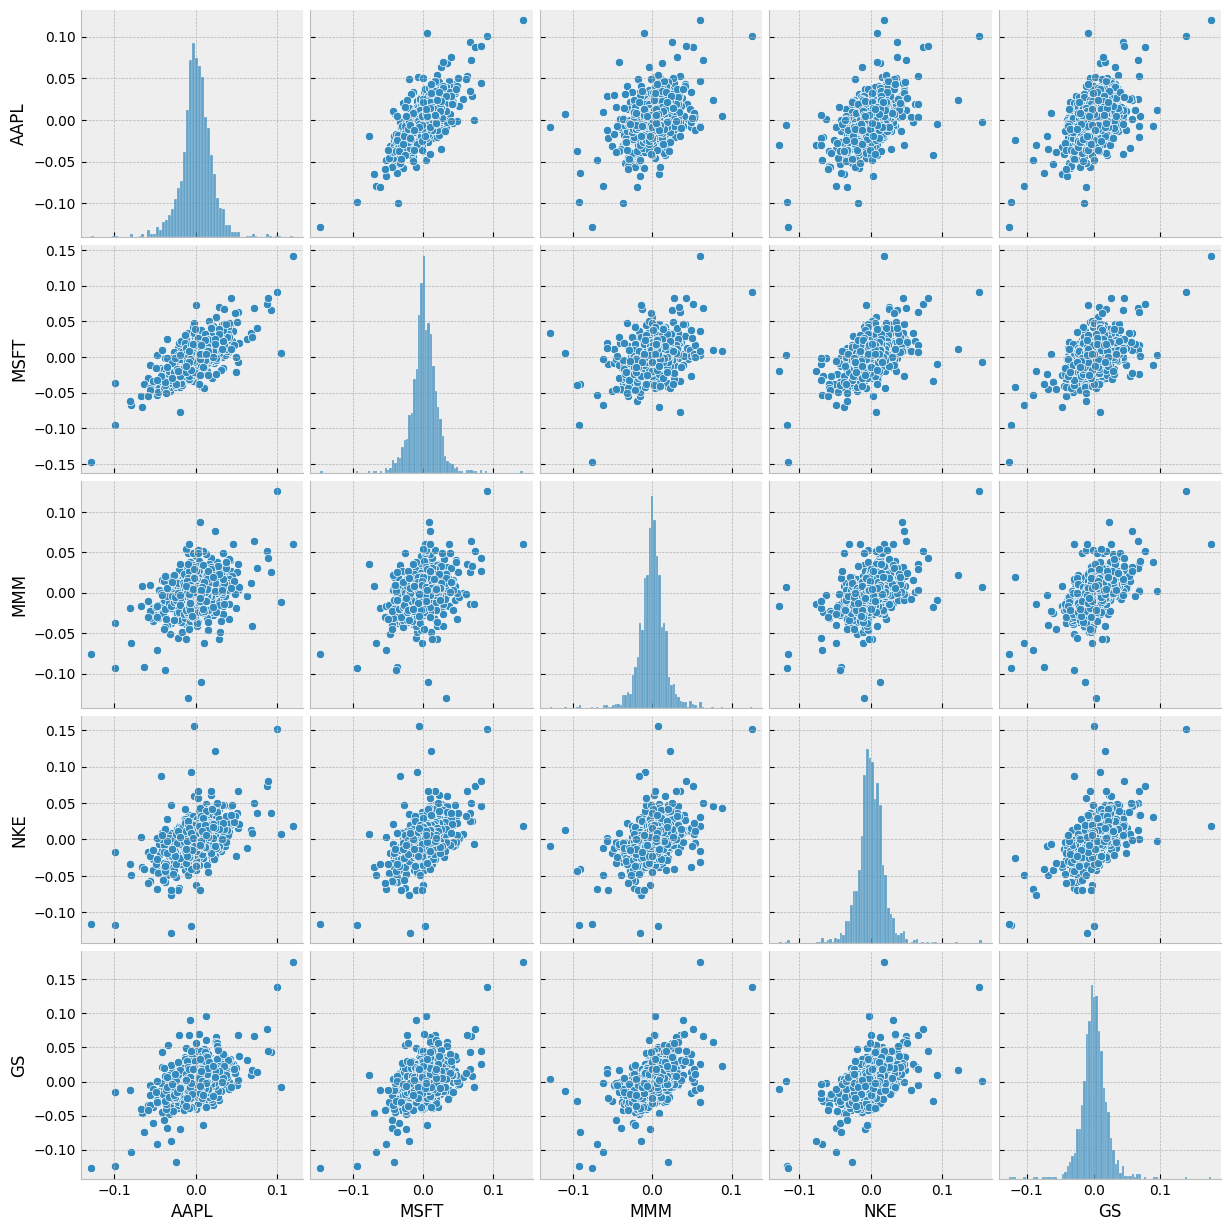

In [7]:
fig = plt.figure(figsize=(7, 7))

sns.pairplot(returns[selected_companies])

plt.show()

Let's consider a case of equally-weighted portfolio with weights $w_i \sim \frac{1}{p_i}$. This way, price changes of all companies will have the same level of contribution in a change of a portfolio

In [8]:
w = 1 / prices.iloc[0]
w = w / w.sum()
portfolio_real_returns = np.dot(returns.values, w)

w_temp = 1 / prices[selected_companies].iloc[0]
w_temp = w_temp / w_temp.sum()
portfolio_real_returns_selected = np.dot(returns[selected_companies].values, w_temp)
portfolio_real_returns_selected = pd.Series(portfolio_real_returns_selected, index=returns.index)

print(w)
print(w_temp)

Ticker
AAPL    0.062000
AXP     0.026505
BA      0.007457
CAT     0.021145
CSCO    0.064595
CVX     0.026701
DIS     0.021867
GS      0.015470
HD      0.015485
IBM     0.027436
INTC    0.057312
JNJ     0.021188
JPM     0.027827
KO      0.058912
MCD     0.015046
MMM     0.019071
MRK     0.038151
MSFT    0.024481
NKE     0.033460
PFE     0.070272
PG      0.029547
RTX     0.039212
TRV     0.022555
UNH     0.010425
V       0.018299
VZ      0.055727
WBA     0.043739
WMT     0.082229
XOM     0.043886
Name: 2019-01-02, dtype: float64
Ticker
AAPL    0.401340
MSFT    0.158470
MMM     0.123454
NKE     0.216598
GS      0.100138
Name: 2019-01-02, dtype: float64


In [9]:
w_temp

Ticker
AAPL    0.401340
MSFT    0.158470
MMM     0.123454
NKE     0.216598
GS      0.100138
Name: 2019-01-02, dtype: float64

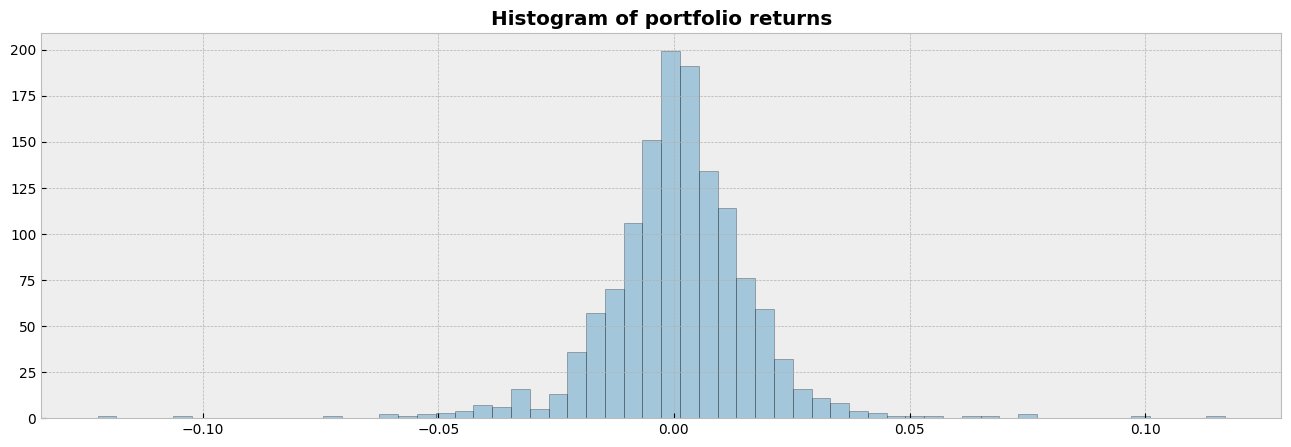

In [10]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of portfolio returns", weight="bold")

plt.show()

And for additional vizualization let's look at join distribution of only two stocks

In [11]:
ticker_one = 'AAPL'
ticker_two = 'MSFT'

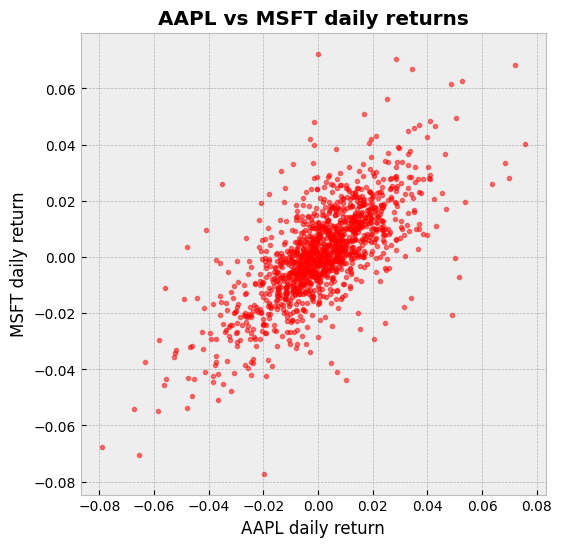

In [12]:
my_lim = 0.08

idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)

x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]

fig = plt.figure(figsize=(6, 6))

plt.plot(x, y, "r.", alpha=0.5)

plt.xlabel("{} daily return".format(ticker_one))
plt.ylabel("{} daily return".format(ticker_two))
plt.title("{} vs {} daily returns".format(ticker_one, ticker_two), weight="bold")

plt.show()

In [13]:
alpha = 0.10

# Important note -- in multivariate case, we cannot take a quantile of some distribution anymore!

Instead, we have to do simulation 

Now even though a portfolo distribution $r^{\text{portfolio}}_t$ is a "univariate random variable", actually it is a weighted sum of several random variables $$ r^{\text{portfolio}}_t = \sum_{j=1}^n w_t^{(j)}r_t^{(j)} = w_t^Tr_t,$$

where each $r_t^{(j)}$ has its own distribution + they could have some correlations, non-linear dependencies etc.


So we:
- fit a joint distribution of $r_t$
- sample from it a lot of pseudo-returns
- multiply it by a vector of weights $w_t^{(j)}$ to get pseudo-portfolio returns
- calculate VaR and ES as quantiles

## Simple models 


### Product of univariate distributions

Let's assume that all $r_t^{(j)}$ are independent and follow t-Student distribution:

$$r_t^{(j)} \sim t(\mu, \sigma^2, df)$$

In [14]:
import scipy.stats as ss

n_samples = 10 ** 4

return_simulations = {}

for col in returns.columns:
    t_df, t_mean, t_sigma = ss.t.fit(returns[col])
    return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)
    
return_simulations = pd.DataFrame(return_simulations)

return_simulations.shape

(10000, 29)

In [15]:
return_simulations[selected_companies]

,AAPL,MSFT,MMM,NKE,GS
0,0.009426,0.008992,0.006762,0.008229,0.008550
1,-0.013394,-0.012770,-0.012027,-0.013802,-0.013626
2,0.019406,0.018631,0.014650,0.017637,0.018188
3,-0.009660,-0.009093,-0.009276,-0.010417,-0.010055
4,0.012663,0.011612,0.010955,0.012340,0.011941
...,...,...,...,...,...
9995,0.002469,0.002930,0.006490,-0.026742,0.003459
9996,0.003091,-0.006079,0.001786,0.026727,-0.015973
9997,-0.010183,-0.008588,0.021317,-0.014568,0.000785
9998,0.027031,0.013597,-0.006399,0.003241,0.005409


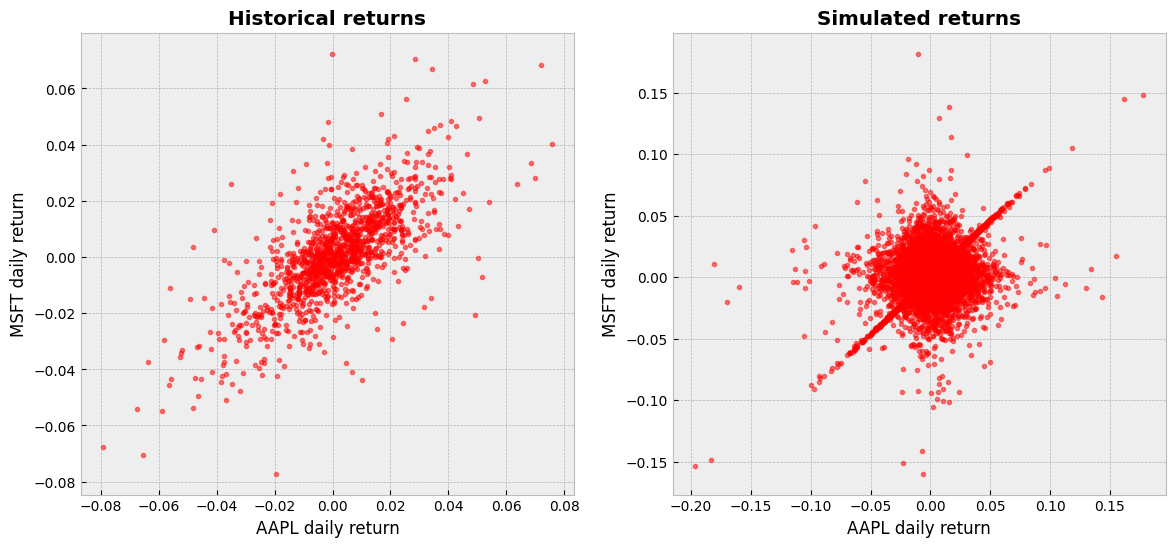

In [16]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.2
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

In [17]:
w

Ticker
AAPL    0.062000
AXP     0.026505
BA      0.007457
CAT     0.021145
CSCO    0.064595
CVX     0.026701
DIS     0.021867
GS      0.015470
HD      0.015485
IBM     0.027436
INTC    0.057312
JNJ     0.021188
JPM     0.027827
KO      0.058912
MCD     0.015046
MMM     0.019071
MRK     0.038151
MSFT    0.024481
NKE     0.033460
PFE     0.070272
PG      0.029547
RTX     0.039212
TRV     0.022555
UNH     0.010425
V       0.018299
VZ      0.055727
WBA     0.043739
WMT     0.082229
XOM     0.043886
Name: 2019-01-02, dtype: float64

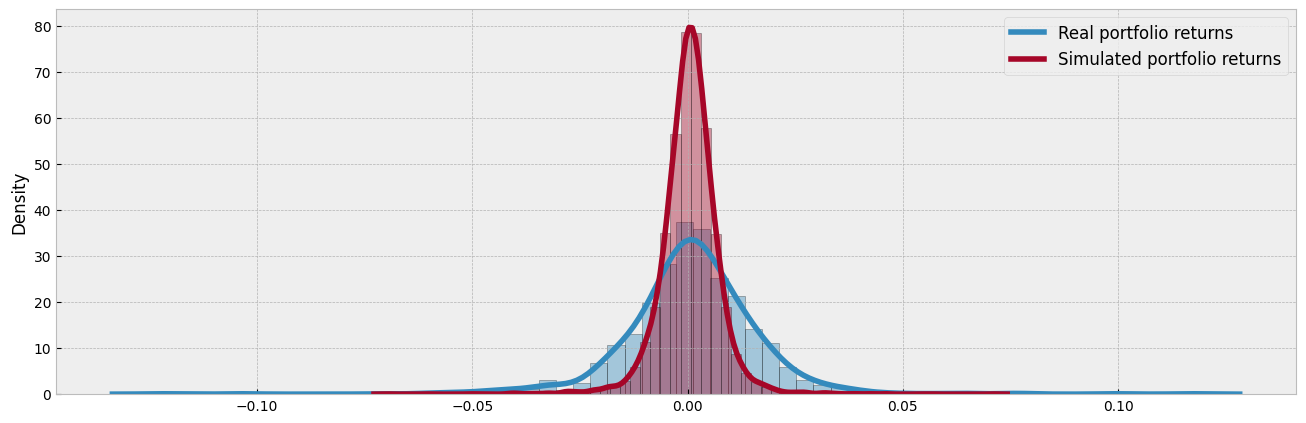

In [18]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [19]:
# умножаем матрицу псевдо-наблюдений на вектор весов и получаем псевдо-наблюдения доходностей портфеля

print(np.quantile(portfolio_real_returns, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.010533404613377565
-0.0066686436261186146


#### Wrapping into functions

In [20]:
from tqdm import tqdm
def make_dummy_student_simulations(returns, n_samples=10**3):
    
    return_simulations = {}

    for col in returns.columns:
        t_df, t_mean, t_sigma = ss.t.fit(returns[col])
        return_simulations[col] = ss.t.rvs(t_df, loc=t_mean, scale=t_sigma, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations)

    return return_simulations


def calc_VaR(r, sampling_fun, w, L_history=252, level=0.05):
    VaR = np.full(r.shape[0], np.nan)
    
    for i in tqdm(list(range(L_history, r.shape[0]))):
        history = r[i - L_history: i]
        
        try:
            return_simulations = sampling_fun(history)
            portfolio_simulated_returns = np.dot(return_simulations.values, w)
            VaR[i] = np.quantile(portfolio_simulated_returns, level)
            
        except:
            VaR[i] = VaR[i-1]
        
    return pd.Series(data=VaR, index=r.index, name=sampling_fun.__name__)

In [23]:
# VaR_HS = calc_VaR(returns[selected_companies], make_dummy_HS_simulations, w_temp)
VaR_t = calc_VaR(returns[selected_companies], make_dummy_student_simulations, w_temp, level=alpha)

 38%|███▊      | 413/1086 [02:24<08:57,  1.25it/s]

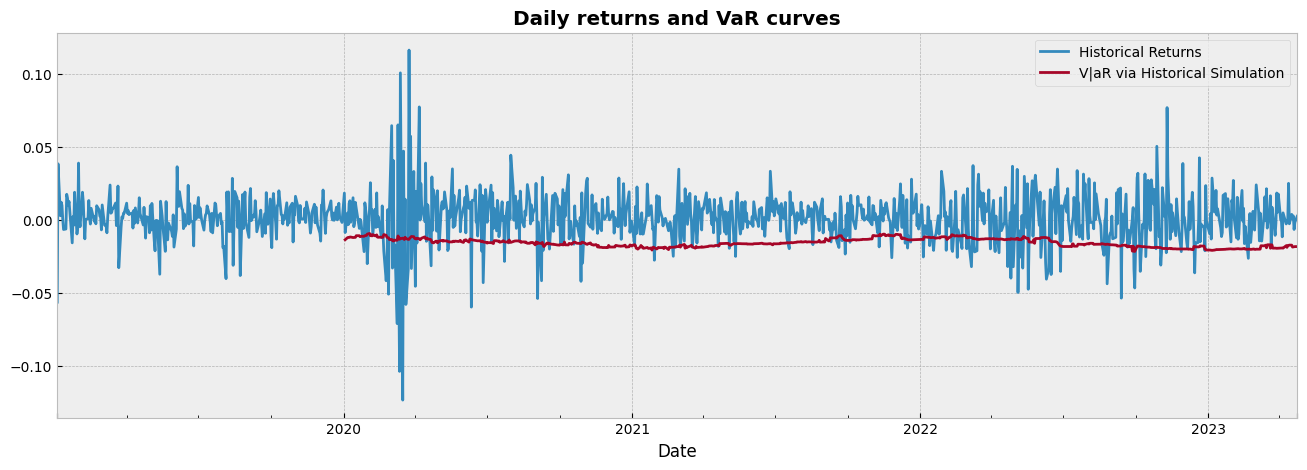

In [22]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
VaR_t.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'V|aR via Historical Simulation',
            'VaR via t-Student disctribution'])

plt.show()

###  Multivariate Normal distribution

Let's assume that

$$r_t \sim N(\mu, \Sigma)$$


where $\mu \in \mathbb{R}^n$ is a mean vector, $\Sigma$ is a covariance matrix

In [21]:
n_samples = 10 ** 4

# estimate parameters of multivariate normal
mean = np.mean(returns.values, axis=0)
cov = np.cov(returns.values, rowvar=False)

# and sample new pseudo-observations
return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

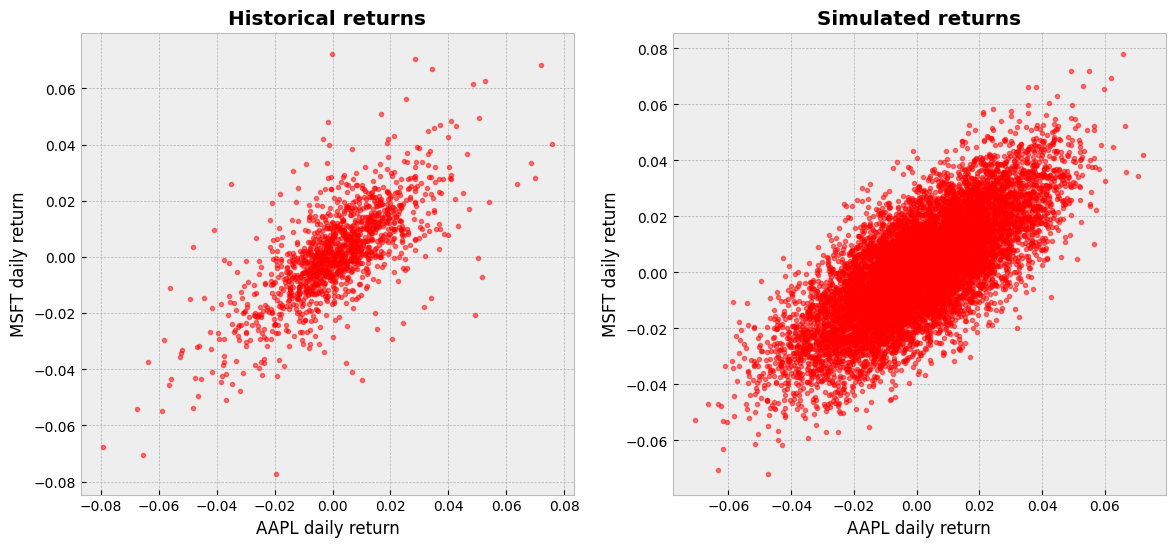

In [22]:
ticker_one = 'AAPL'
ticker_two = 'MSFT'

fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.2
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

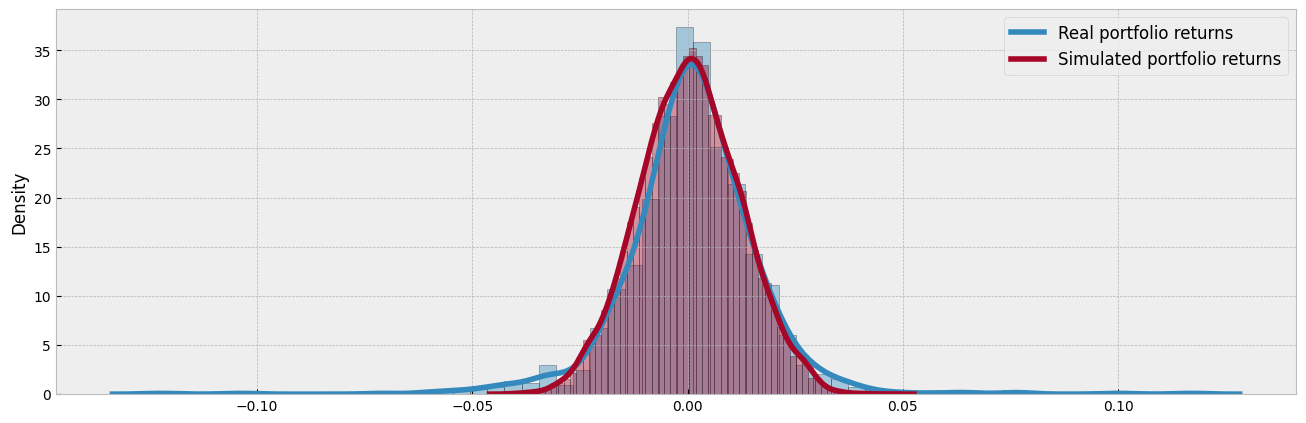

In [23]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [24]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.015835003716115726
-0.014577777929955045


#### Wrapping into functions

In [25]:
def make_mult_normal_simulations(returns, n_samples=10**3):

    mean = np.mean(returns.values, axis=0)
    cov = np.cov(returns.values, rowvar=False)

    return_simulations = ss.multivariate_normal.rvs(mean=mean, cov=cov, size=n_samples, random_state=42)

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [26]:
VaR_multy_normal = calc_VaR(returns[selected_companies], make_mult_normal_simulations, w_temp, level=alpha)

100%|██████████| 1086/1086 [00:00<00:00, 1383.30it/s]


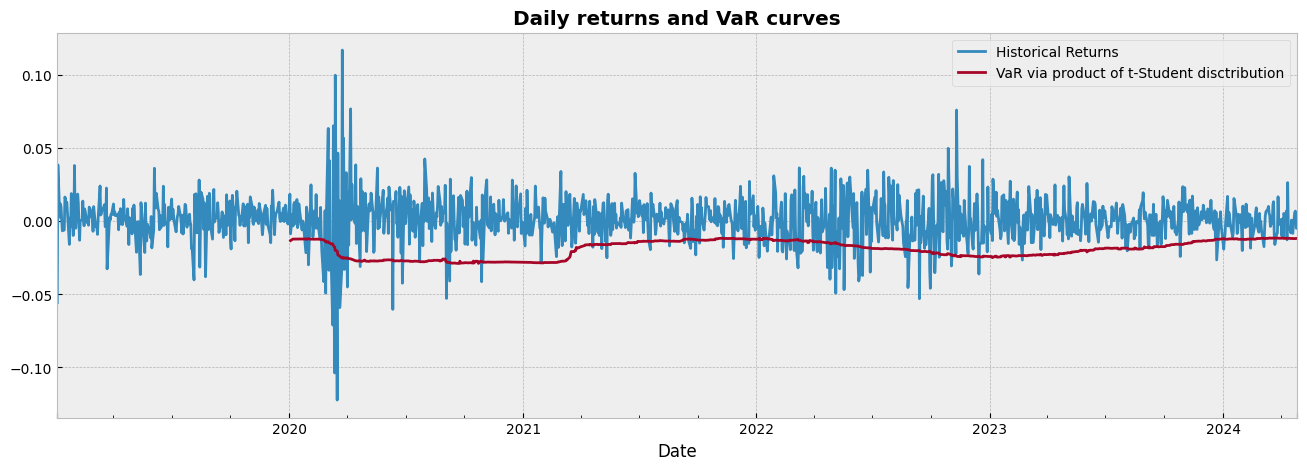

In [29]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
# VaR_t.plot()
VaR_multy_normal.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
            'VaR via product of t-Student disctribution',
           'VaR via Multivariate normal'])

plt.show()

###  Kernel Density estimation

Here we do not assume any distribution of $r_t$, but trying to estimate the probability density function of a random variable

#### Univariate case

Let's firstly look at univariate case of one $x = r_t^{(j)}$. Let $(x_1, x_2, …, x_m)$ be a univariate independent and identically distributed sample drawn from some distribution with an unknown density $ƒ$. We are interested in estimating the shape of this function $ƒ$. Its kernel density estimator is

$$ \hat{ƒ}(x) = \frac{1}{mh} \sum_{i=1}^m K(\frac{x-x_i}{h})$$

where $K$ is the kernel — a non-negative function — and $h > 0$ is a smoothing parameter called the bandwidth. There are several options for kernel functions, one common is a Gaussian kernel $K(z) = \frac{1}{\sqrt{2\pi}}e^{-z^2/2}$

In [32]:
ret = returns.loc[:, ticker_one].values

kde = ss.gaussian_kde(ret)

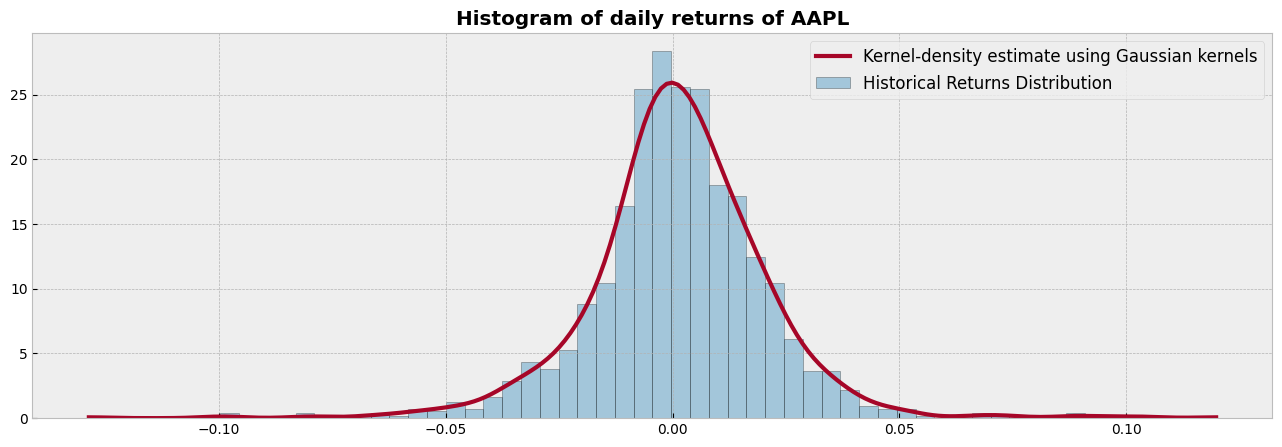

In [33]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = kde.pdf(x)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns of {}".format(ticker_one), weight="bold")
plt.legend(['Kernel-density estimate using Gaussian kernels', 
            'Historical Returns Distribution'], fontsize=12)

plt.show()

#### Multivariate case

In the multivariate case, kernel density estimator is

$$ \hat{ƒ}(x) = \frac{1}{m|H|} \sum_{i=1}^m K(H^{-1}(x-x_i))$$

where $K$ is the kernel and $H$ is a smoothing matrix. Multivariate Gaussian kernel $K(z) = \frac{1}{(2\pi)^{n/2}}e^{\frac{-z^Tz}{2}}$

In [36]:
n_samples = 10 ** 3

# estimate parameters of multivariate normal
kde = ss.gaussian_kde(returns.values.T)

# and sample new pseudo-observations
return_simulations = kde.resample(size=n_samples).T

return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

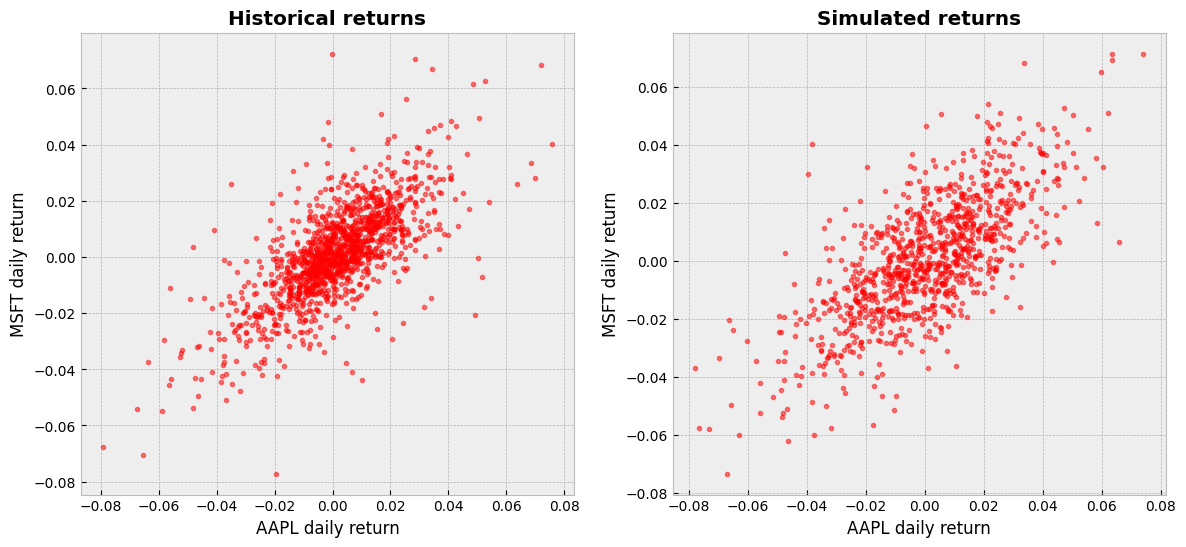

In [37]:
fig = plt.figure(figsize=(14, 6))

plt1 = fig.add_subplot(1,2,1)
plt2 = fig.add_subplot(1,2,2)

my_lim = 0.08
idx = (np.abs(returns[ticker_one]) < my_lim) & (np.abs(returns[ticker_two]) < my_lim)
x = returns.loc[idx, ticker_one]
y = returns.loc[idx, ticker_two]
plt1.plot(x, y, "r.", alpha=0.5)

plt1.set_xlabel("{} daily return".format(ticker_one))
plt1.set_ylabel("{} daily return".format(ticker_two))
plt1.set_title("Historical returns", weight="bold")


my_lim = 0.08
idx = (np.abs(return_simulations[ticker_one]) < my_lim) & (np.abs(return_simulations[ticker_two]) < my_lim)
x = return_simulations.loc[idx, ticker_one]
y = return_simulations.loc[idx, ticker_two]
plt2.plot(x, y, "r.", alpha=0.5)

plt2.set_xlabel("{} daily return".format(ticker_one))
plt2.set_ylabel("{} daily return".format(ticker_two))
plt2.set_title("Simulated returns", weight="bold")

plt.show()

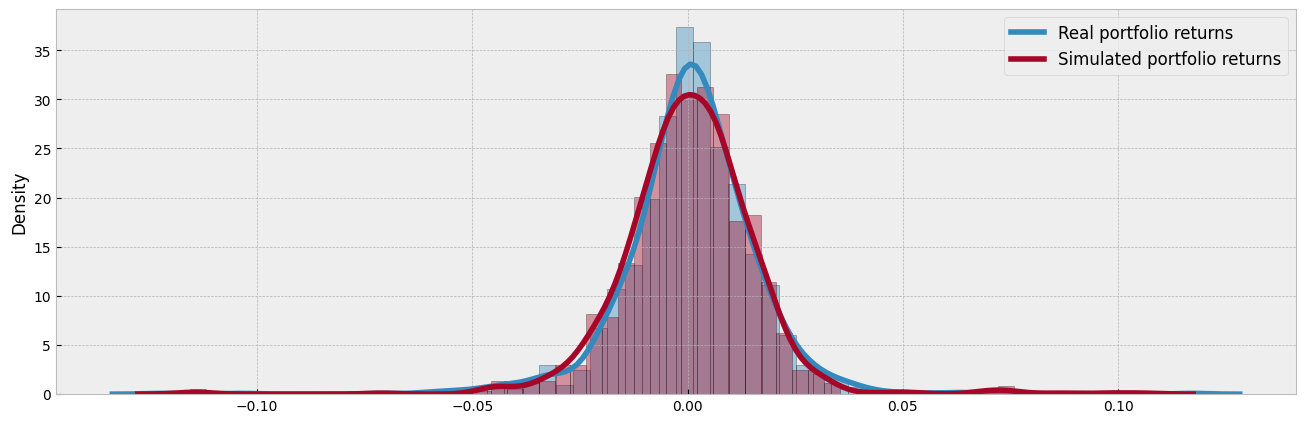

In [38]:
portfolio_simulated_returns = np.dot(return_simulations.values, w)

fig = plt.figure(figsize=(16, 5))

sns.distplot(portfolio_real_returns_selected, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(portfolio_simulated_returns, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.legend(['Real portfolio returns',
            'Simulated portfolio returns'], fontsize=12)
plt.show()

In [39]:
print(np.quantile(portfolio_real_returns_selected, alpha))
print(np.quantile(portfolio_simulated_returns, alpha))

-0.015835003716115726
-0.01632881510042969


In [42]:
def make_mult_kde_simulations(returns, n_samples=10**3):

    # estimate parameters of multivariate normal
    kde = ss.gaussian_kde(returns.values.T)

    # and sample new pseudo-observations
    return_simulations = kde.resample(size=n_samples).T

    return_simulations = pd.DataFrame(return_simulations, columns=returns.columns)

    return return_simulations

In [41]:
VaR_multy_kde = calc_VaR(returns[selected_companies], make_mult_kde_simulations, w_temp, level=alpha)


100%|██████████| 1086/1086 [00:00<00:00, 1634.62it/s]


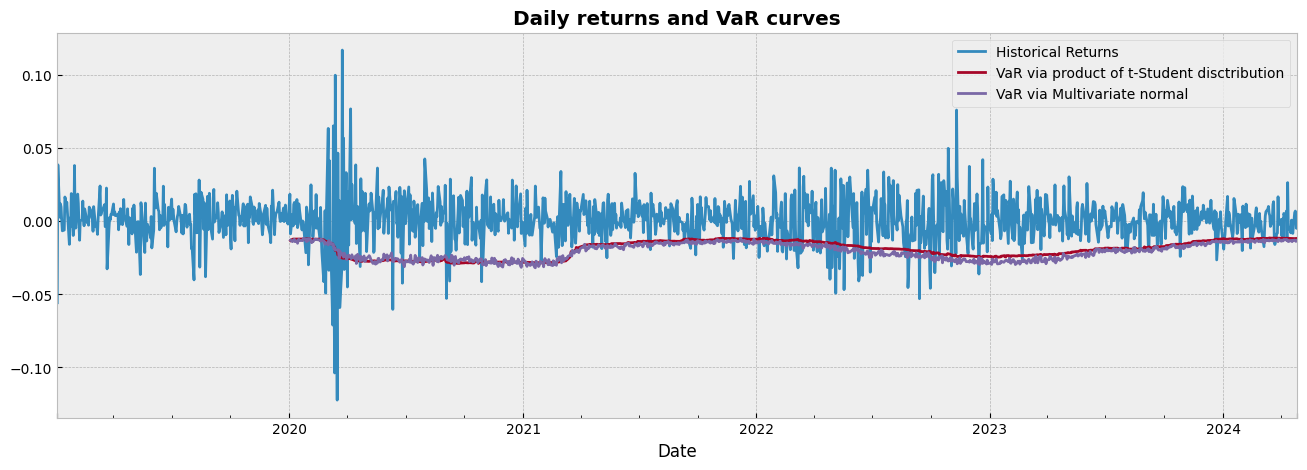

In [43]:
fig = plt.figure(figsize=(16, 5))

portfolio_real_returns_selected.plot()
# VaR_HS.plot()
# VaR_t.plot()
VaR_multy_normal.plot()
VaR_multy_kde.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
#             'VaR via Historical Simulation',
            'VaR via product of t-Student disctribution',
           'VaR via Multivariate normal',
           'VaR via Multivariate KDE'
           ])

plt.show()

## Backtesting VaR

In [44]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))


def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [42]:
backtest_results(portfolio_real_returns_selected, VaR_t, alpha)

Target share of violations: 10.00%
Observed share of violations: 13.70%

Test for coverage isn't passed

Test for independence isn't passed


In [45]:
backtest_results(portfolio_real_returns_selected, VaR_multy_normal, alpha)

Target share of violations: 10.00%
Observed share of violations: 8.84%

Test for coverage is passed

Test for independence isn't passed


In [46]:
backtest_results(portfolio_real_returns_selected, VaR_multy_kde, alpha)

Target share of violations: 10.00%
Observed share of violations: 7.92%

Test for coverage isn't passed

Test for independence isn't passed
